# NR/SVD-Cdyn example

In [2]:
library(zoo)

In [3]:
get_bins <- function(HIST_MIN=2,HIST_MAX=10,NUM_BINS=200) {
    #' creates bins for binned WHAM
    #' HIST_MIN and HIST_MAX denote the range of distances for binning
    #' NUM_BINS: number of bins for the analysis
    BINS <- seq(HIST_MIN,HIST_MAX,length.out=NUM_BINS+1)
    MID_BINS <- zoo::rollsum(BINS,2)/2
    list(bins=BINS,
         mids=MID_BINS,
         min=HIST_MIN,
         max=HIST_MAX,
         n=NUM_BINS)
}

In [4]:
process_UmbrellaSampling <- function(dir=".",bins,column=2,k=100,Temperature=300,remove_outliers=TRUE) {
    #' Reads a series of input files from the Umbrella Sampling (US) simulations
    #' Each file is assumed to have the filename matching pattern "dist_X.XXX.dat" where X.XXX is the
    #' restraint value of the geometrical parameter
    #' k: vector of force constants
    #' for the biasing potential calculation (E=0.5*k*dQ^2)
    #'   If length(k)==1, the same value of k will be used for every US simulation
    #'   if length(k) is equal to the number of the US simulations, then individual constants will be applied
    #'
    #' T: temperature (in K). US simulation-specific temperatures could be used
    #'
    
    # get the list of files with distances
    LF <- list.files(dir,pattern = "dist_.*dat",full.names = TRUE)

    # read the files into a list of data frames
    df <- lapply(LF,read.table)

    # extract the centers of the restraining harmonic potentials from the names of the files
    Q <- gsub(".*dist_(.*?).dat","\\1",LF) %>% as.numeric()

    # Numerically sort df and Q according to distance
    df <- df[order(Q)]
    Q <- Q[order(Q)]

    # add the restraining distance as dist into each data frame
    df2 <- lapply(seq_along(df),function(i) {d <- df[[i]][,column,drop=FALSE]; d$Q <- Q[i]; d})

    # combine a list of individual data frames into a single data frame
    D <- do.call(rbind,df2)

    # m is the matrix with counts; 
    # Each column represent a distance bin 
    # Each row represents a histogram for an individual US simulation
    m <- sapply(df,function(d) {
          v <- d[,column]
          v <- if (remove_outliers) v[v > bins$min & v < bins$max] else v
          hist(v,breaks = bins$bins,plot = FALSE)$counts}
        ) %>% t()

    list(m=m,Q_US=Q,D=D)
}


In [5]:
# generate bins
bins <- get_bins(HIST_MIN=2.25,HIST_MAX=13,NUM_BINS=500)

In [6]:
# process the input data files
dUS <- process_UmbrellaSampling('./dist/',bins,k=100,Temperature = 300)

In [7]:
generate_funs_Roux <- function(m,dist,MID_BINS,k,Temperature) {
  #' Generates auxillary functions that calculate probabilty, free energy, etc
  #' Equations used here are identical or closely follow those given in the WHAM program and Benoit Roux paper
  #'
  #' m is the matrix with the rows corresponding to the Umbrella Sampling simulations, and columns--to the distance histogram within each simulation [JxI]
  #' dist -- series of the harmonic constraint distances
  #' k -- force constant for the harmonic potential
  #' Temperature -- a vector of temperatures used in each simulation
 
  # Boltzmann constant
  k_B <- 0.0019872041 # kcal/mol/K

  RT <- k_B*Temperature

  b1 <- outer(dist,MID_BINS,function(x,y) (x-y)^2)
  b2 <- ( k/2/RT*diag(nrow(m)) ) %*% b1 # [JxJ] %*% [JxI] -> [JxI] ; bias
  B <- exp(-b2)                         # B or ebias

  NJ <- rowSums(m) # [1xJ] ; NCi in paper
  NI <- colSums(m) # [1xI] ; NRj in paper

  calc_vecs <- function(f) {
    F <- exp(f/RT)

    D <- as.vector((NJ*F) %*% B)         # Partition functions [1xI]
    P <- NI / D                          # Unnormalized unbiased probability distribution [1xI]
    Fn <- as.vector(P %*% t(B))          # Update F vector [1xI] %*% [IxJ] -> [1xJ]
    ER <- -RT*log(Fn) - f                # 'Error' vector [1xJ]
    R2 <- crossprod(ER) %>% as.vector()  # R2 is the squared norm of the 'error' vector

    list(F=F,D=D,P=P,Fn=Fn,ER=ER,R2=R2)
  }

  calc_grads <- function(f,v=NULL) {
    # calculate first derivatives
    v <- if (is.null(v)) calc_vecs(f) else v
    with(v,{
      dD <- diag(NJ*F/RT) %*% B                          # [JxJ] %*% [JxI] -> [JxI];             dD[j,i] = d(D[i])/d(f[j])
      d_sumP <- as.vector((-NI/D^2) %*% t(dD))           # [1xI] %*% [IxJ] -> [1xJ];             d_sumP[j] = d(sum_P)/d(f[j])
      dFn <- -(B %*% diag(NI/D^2)) %*% t(dD)             # [JxI] %*% [IxI] %*% [IxJ] -> [JxJ];   dFn[j,k] = d(Fn[k])/d(f[j])
      dER <- -diag(RT/Fn) %*% dFn - diag(length(Fn))     # [JxJ] %*% [JxJ] -> [JxJ];             dER[j,k] = d(ER[k])/d(f[j])
      dR2 <- as.vector(2 * (ER %*% dER))                 # [1xJ] %*% [JxJ] -> [1xJ];             dR2[j] = d(R2)/d(f[j])

      list(dD=dD,dFn=dFn,dER=dER,dR2=dR2,d_sumP=d_sumP)
    })
  }

  calc_hess <- function(f) {
    # calculate second derivatives
    v <- calc_vecs(f)
    g <- calc_grads(f,v)
    # d2D <- lapply(seq_along(v$D), function(i) diag(g$dD[,i]/RT)) # not used
    d2Fn <- lapply(seq_along(f), function(k) {                                            # d2Fn_k[j,m] <- d2(Fn[k]) / (d(f[j])*d(f[m]))
      diag(g$dF[k,]/RT) + 2*( (g$dD %*% diag(NI*as.vector(B[k,])/v$D^3)) %*% t(g$dD))     # [JxI] %*% [IxI] %*% [IxJ] -> [JxJ]
    })

    d2ER <- lapply(seq_along(f), function(k) (-RT/v$Fn[k]^2)*(v$Fn[k]*d2Fn[[k]] - tcrossprod(g$dF[k,])))   # d2ER_k[j,m] <- d2(ER[k]) / (d(f[j])*d(f[m]))

    d2R2 <- lapply(seq_along(f), function(k) v$ER[k]*d2ER[[k]] + tcrossprod(g$dER[k,]))
    d2R2 <- 2*Reduce("+",d2R2)

    list(d2ER=d2ER,d2R2=d2R2)
  }

  A_f <- function(f,T=300) {
    # get Free energy profile for given f-vectors
    P <- P_f(f)
    RT <- k_B*T
    A <- -RT*log(P)
    A <- A-min(A)
    data.frame(R=MID_BINS,P=P,A=A)
  }

  # Wrappers
  P_f <- function(f) calc_vecs(f)$P
  sumP_f <- function(f) sum(P_f(f))
  d_sumP_f <- function(f) calc_grads(f)$d_sumP

  ER_f <- function(f) calc_vecs(f)$ER
  R2_f <- function(f) calc_vecs(f)$R2
  mx   <- function(f) max(abs(calc_vecs(f)$ER))

  grad_ER_f <- function(f) calc_grads(f)$dER
  grad_R2_f <- function(f) calc_grads(f)$dR2
  grad_P_f <- function(f) calc_grads(f)$dP

  hess_ER_f <- function(f) calc_hess(f)$d2ER
  hess_R2_f <- function(f) calc_hess(f)$d2R2

  list(ER=ER_f, grad_ER=grad_ER_f, hess_ER=hess_ER_f,
       R2=R2_f, grad_R2=grad_R2_f, hess_R2=hess_R2_f,
       P=P_f,
       sumP=sumP_f,grad_sumP=d_sumP_f,
       A=A_f,
       mx=mx)t
}


In [8]:
# generate the functions that will return the error function norm, values, and Jacobian
funs <- generate_funs_Roux(dUS$m,dUS$Q_US,bins$mids,k = 100,Temperature = 300)

In [9]:
# generate the initial guess
f0 <- rep(0,length(dUS$Q_US))

In [10]:
NR_SVD <- function(f_start,fn,ER,Jacobian,alpha=1,MAXIT=1000,THRESHOLD=1e-5,G_THRESHOLD=1e-10,k0=2,Cmax=1e9,base=1e3,DEBUG=FALSE,DOWN=50) {
  #' Optimizes a vector function RN-->R using modified Newton-Raphson algorithm, NR-SVD/Cdyn
  #' f_start: Initial guess vector
  #' fn: Function that returns a single-valued error for a given guess vector
  #' ER: Function RN-->RN for which the roots are sought
  #' Jacobian: Function that returns Jacobian for ER

  f <- f_start
  bconv <- FALSE # Boolean convergence
  conv <- NULL   # Convergence (norm of the step size)
  conv_old <- Inf
  conv_hist <- numeric(MAXIT) # needed to return the step size norm history
  fn_hist <- numeric(MAXIT)   # needed to return the fn history

  k_max <- log(Cmax,base) %>% ceiling()
  k_min <- 1
  base_min <- 1.01

  for (iter in seq(MAXIT)) {

    if (DEBUG) { sprintf('Starting iteration %i',iter) %>% message() }

    # Try to get the SVD of the matrix
    sv <- tryCatch(svd(Jacobian(f)),
                   error=function(e) {
                     if(e$message=="infinite or missing values in 'x'") NULL
                   }
    )
    if (iter %% DOWN==0) {
      if (base>1.01) {
        base <- sqrt(base)
        k0 <- 2
        f <- f - mean(f)
        if (DEBUG) {sprintf('Iteration %i: slow convergence, reduce base value to %.3f',iter,base) %>% message()}
      }
    }
    if (is.null(sv)) {
      if (base>1.01) {
        base <- sqrt(base)
        if (DEBUG) {sprintf('SVD error at iteration %i, restart with reduced base value %.3f',iter,base) %>% message()}
        k0 <- 2
        f <- f_start
        conv_hist[iter] <- conv_old
        fn_hist[iter] <- fn(f)
        next()
      } else {
        sprintf('SVD error at iteration %i; base value is below the lowest possible value; stop',iter) %>% message()
        break()
      }
    }

    dp <- 1/sv$d
    dp[dp/dp[1]>base^k0] <- 0 # http://www.wag.caltech.edu/publications/sup/pdf/341.pdf
    G_minus <- sv$v %*% diag(dp) %*% t(sv$u)

    h <- -alpha * as.vector(G_minus %*% ER(f))

    f <- f + h

    # get the step size norm
    conv <- crossprod(h,h)

    # update the records
    conv_hist[iter] <- conv
    fn_hist[iter] <- fn(f)

    if (DEBUG) print(k0)

    if (conv < conv_old) k0 <- min(k0+1,k_max)
    if ((conv > THRESHOLD) & (conv > conv_old)) k0 <- max(k0-1,k_min)

    if ((conv < THRESHOLD) & (sum(ER(f-h)^2) > G_THRESHOLD)) {
      k_max <- ceiling(log(1e15,base))
      k0 <- k_max
    }

    bconv <- (conv < THRESHOLD) & (sum(ER(f-h)^2) < G_THRESHOLD) & (k0>=k_max)
    if (bconv) break;

    # Do not scale down the step size after the first iteration
    alpha <- 1

    # Save old conv to check for improvement in the next step
    conv_old <- conv
  }
  list(convergence=bconv,iter=iter,norm=conv,optim=f,
       conv_hist=conv_hist[1:iter],fn_hist=fn_hist[1:iter],
       #G_minus=G_minus,ER=ER(f-h),
       k0=k0)
}


In [11]:
MAXIT <- 50
THRESHOLD <- 1e-20
OUT_SVD <- NR_SVD(f0,fn=funs$R2,ER=funs$ER,Jacobian=funs$grad_ER,THRESHOLD=THRESHOLD,MAXIT=MAXIT)

In [12]:
Free_energies <- funs$A(OUT_SVD$optim)

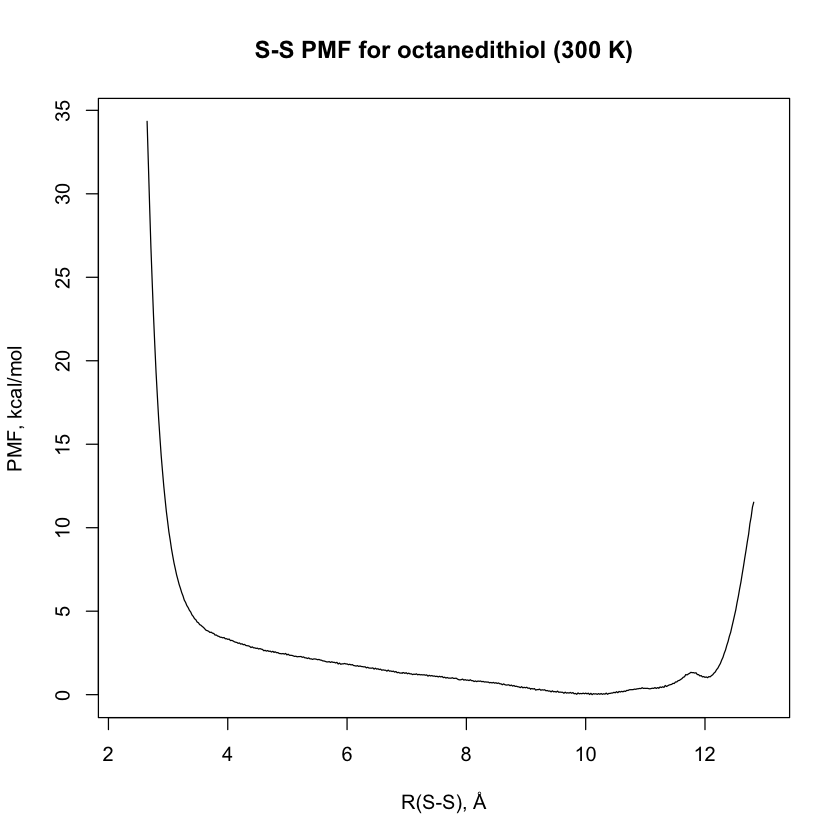

In [13]:
plot(A~R, Free_energies,type='l',main='S-S PMF for octanedithiol (300 K)',xlab='R(S-S), Å',ylab='PMF, kcal/mol')